In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import numba

from typing import Dict

from saturation.simulation import *
from saturation.distributions import *
from saturation.geometry import *
from saturation.plotting import *

In [24]:
def plot_statistics(stats: pd.DataFrame):
    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 8))

    # Plot crater count
    ax = axes[0][0]
    ax.plot(stats.n_craters_generated, stats.n_craters_in_observation_area_min)
    ax.plot(stats.n_craters_generated, stats.n_craters_in_observation_area_25_percentile)
    ax.plot(stats.n_craters_generated, stats.n_craters_in_observation_area_mean)
    ax.plot(stats.n_craters_generated, stats.n_craters_in_observation_area_75_percentile)
    ax.plot(stats.n_craters_generated, stats.n_craters_in_observation_area_max)
    ax.set_xlabel('Craters Generated')
    ax.set_ylabel('Observable Craters')

    # Plot crater count
    ax = axes[0][1]
    ax.plot(stats.n_craters_generated, stats.areal_density_min)
    ax.plot(stats.n_craters_generated, stats.areal_density_25_percentile)
    ax.plot(stats.n_craters_generated, stats.areal_density_mean)
    ax.plot(stats.n_craters_generated, stats.areal_density_75_percentile)
    ax.plot(stats.n_craters_generated, stats.areal_density_max)
    ax.set_xlabel('Craters Generated')
    ax.set_ylabel('Areal Density')

    # Plot Z statistic
    ax = axes[1][0]
    ax.plot(stats.n_craters_generated, stats.z_min)
    ax.plot(stats.n_craters_generated, stats.z_25_percentile)
    ax.plot(stats.n_craters_generated, stats.z_mean)
    ax.plot(stats.n_craters_generated, stats.z_75_percentile)
    ax.plot(stats.n_craters_generated, stats.z_max)
    ax.axhline(-1.96, color='g', ls='--')
    ax.axhline(1.96, color='g', ls='--')
    ax.axhline(-2.58, color='r', ls='--')
    ax.axhline(2.58, color='r', ls='--')
    ax.set_xlabel('Craters Generated')
    ax.set_ylabel('Z Statistic')

    # Plot Za statistic
    ax = axes[1][1]
    ax.plot(stats.n_craters_generated, stats.za_min)
    ax.plot(stats.n_craters_generated, stats.za_25_percentile)
    ax.plot(stats.n_craters_generated, stats.za_mean)
    ax.plot(stats.n_craters_generated, stats.za_75_percentile)
    ax.plot(stats.n_craters_generated, stats.za_max)
    ax.axhline(-1.96, color='g', ls='--')
    ax.axhline(1.96, color='g', ls='--')
    ax.axhline(-2.58, color='r', ls='--')
    ax.axhline(2.58, color='r', ls='--')
    ax.set_xlabel('Craters Generated')
    ax.set_ylabel('Za Statistic')

    plt.show()


In [5]:
def percentile(n):
    @numba.jit(forceobj=True, fastmath=True)
    def _percentile(x):
        return np.percentile(x, n)
    return _percentile

In [18]:
base_path = '/home/mason/output/'
filenames = [
    f'{base_path}/sim_run_1_3_0.4_1.5_{x}.txt'
    for x in range(35)
]

sim_stats = []
for index, filename in enumerate(filenames):
    stats = pd.read_csv(filename)
    stats['simulation_id'] = index
    sim_stats.append(stats)

stats = pd.concat(sim_stats, axis=0).dropna()

In [19]:
columns_to_aggregate = [
    'n_craters_in_observation_area',
    'areal_density',
    'z',
    'za'
]
aggregations = {
    x: [
        'min',
        pd.NamedAgg(column=x, aggfunc=percentile(25)),
        'mean',
        pd.NamedAgg(column=x, aggfunc=percentile(75)),
        'max'
    ]
    for x in columns_to_aggregate
}
col_names = [
    [
        f'{x}_min',
        f'{x}_25_percentile',
        f'{x}_mean',
        f'{x}_75_percentile',
        f'{x}_max',
    ]
    for x in columns_to_aggregate
]
col_names = [y for x in col_names for y in x]

grouped = stats.groupby(['n_craters_generated']).agg(
    aggregations
)

grouped.columns = col_names
grouped.reset_index(inplace=True)

In [20]:
grouped.tail()

,n_craters_generated,n_craters_in_observation_area_min,n_craters_in_observation_area_25_percentile,n_craters_in_observation_area_mean,n_craters_in_observation_area_75_percentile,n_craters_in_observation_area_max,areal_density_min,areal_density_25_percentile,areal_density_mean,areal_density_75_percentile,...,z_min,z_25_percentile,z_mean,z_75_percentile,z_max,za_min,za_25_percentile,za_mean,za_75_percentile,za_max
4994,4996,278,724.5,839.542857,954.0,1462,0.262522,0.339684,0.395796,0.439057,...,-9.435579,-4.929330,-3.945707,-2.685640,1.229506,-0.848755,7.634424,10.889845,14.129669,22.718252
4995,4997,279,716.5,833.428571,955.0,1463,0.262529,0.339735,0.398308,0.439141,...,-9.344868,-5.048541,-4.025052,-2.679350,1.180355,-0.730102,7.248665,10.843930,14.228218,22.806634
4996,4998,280,717.0,833.514286,956.0,1464,0.262539,0.339735,0.398548,0.439156,...,-9.370786,-5.066671,-4.013978,-2.602117,0.840207,-0.769787,7.264127,10.877745,14.071323,22.996067
4997,4999,281,718.0,832.628571,957.0,1465,0.262541,0.339737,0.398390,0.439162,...,-9.600828,-4.984053,-4.007662,-2.567761,0.769511,-1.041723,7.309352,10.874403,14.091055,23.145803
4998,5000,282,719.0,833.628571,958.0,1466,0.262545,0.339739,0.398401,0.439165,...,-9.729470,-4.913589,-4.003934,-2.633022,0.689660,-1.190141,7.339741,10.889935,14.023567,23.235941


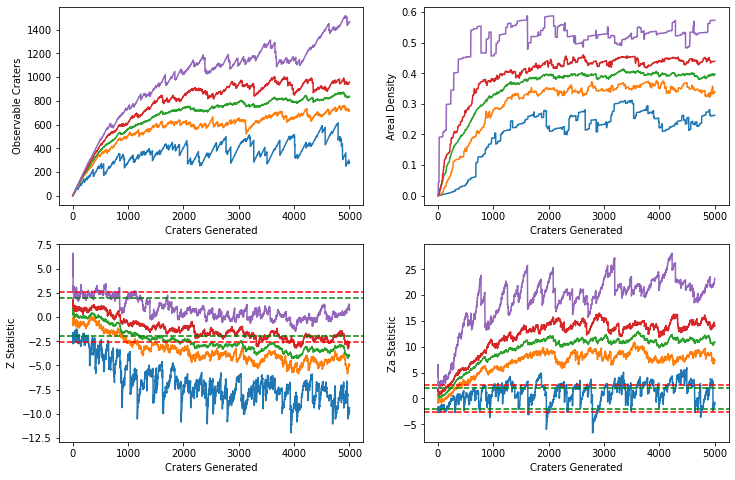

In [25]:
plot_statistics(grouped)

In [26]:
base_path = '/home/mason/code/kirchoff_saturation/output/'
filenames = [
    f'{base_path}/run_-1.00_1.50_0.40_3.00_{x}_1.csv'
    for x in range(1, 55)
]

sim_stats = []
for index, filename in enumerate(filenames):
    stats = pd.read_csv(filename, skiprows=1)
    stats.columns = ['n_craters_generated', 'n_craters_in_observation_area', 'areal_density', 'z', 'za']
    stats.areal_density = stats.areal_density / 10000**2
    stats['simulation_id'] = index
    sim_stats.append(stats)

stats = pd.concat(sim_stats, axis=0).dropna()

In [27]:
columns_to_aggregate = [
    'n_craters_in_observation_area',
    'areal_density',
    'z',
    'za'
]
aggregations = {
    x: [
        'min',
        pd.NamedAgg(column=x, aggfunc=percentile(25)),
        'mean',
        pd.NamedAgg(column=x, aggfunc=percentile(75)),
        'max'
    ]
    for x in columns_to_aggregate
}
col_names = [
    [
        f'{x}_min',
        f'{x}_25_percentile',
        f'{x}_mean',
        f'{x}_75_percentile',
        f'{x}_max',
    ]
    for x in columns_to_aggregate
]
col_names = [y for x in col_names for y in x]

grouped = stats.groupby(['n_craters_generated']).agg(
    aggregations
)

grouped.columns = col_names
grouped.reset_index(inplace=True)

In [28]:
grouped.tail()

,n_craters_generated,n_craters_in_observation_area_min,n_craters_in_observation_area_25_percentile,n_craters_in_observation_area_mean,n_craters_in_observation_area_75_percentile,n_craters_in_observation_area_max,areal_density_min,areal_density_25_percentile,areal_density_mean,areal_density_75_percentile,...,z_min,z_25_percentile,z_mean,z_75_percentile,z_max,za_min,za_25_percentile,za_mean,za_75_percentile,za_max
4996,4996,446,699.0,825.314815,963.00,1264,0.158551,0.254426,0.295120,0.347275,...,-10.01,-5.6275,-4.337037,-3.0825,-0.61,-6.14,3.0775,5.604259,8.9800,15.68
4997,4997,447,695.0,824.870370,963.75,1265,0.158610,0.254481,0.295833,0.347276,...,-9.90,-5.6700,-4.366481,-3.1275,-0.57,-6.03,3.0325,5.591296,8.9275,15.88
4998,4998,407,696.0,822.092593,964.75,1266,0.173722,0.254492,0.295775,0.347277,...,-9.68,-5.7000,-4.455370,-3.1025,-0.53,-5.77,2.9125,5.464444,8.9950,15.80
4999,4999,408,697.0,822.888889,965.75,1267,0.173722,0.254567,0.295910,0.347278,...,-9.62,-5.7650,-4.457963,-3.1375,-0.51,-5.70,2.8625,5.472222,9.0725,15.78
5000,5000,621,767.0,869.470588,913.00,1268,0.173790,0.245432,0.285922,0.326221,...,-7.56,-5.9900,-4.866471,-3.9400,-0.88,-1.35,1.7700,4.850588,7.6900,15.57


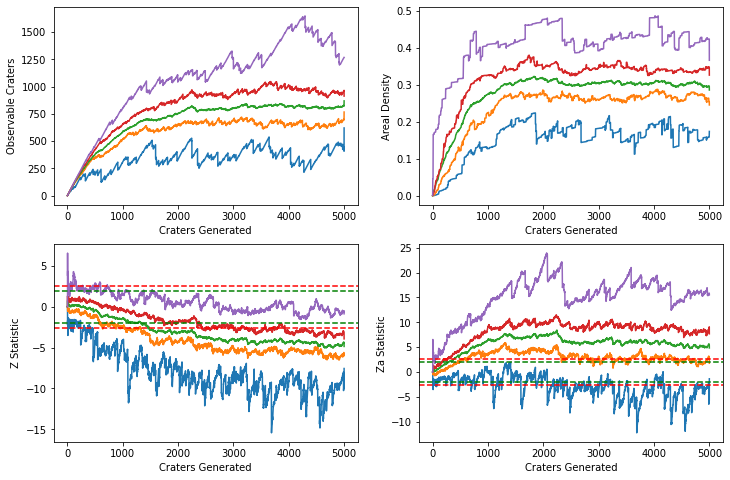

In [29]:
plot_statistics(grouped)